In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
from keras_preprocessing import image
import numpy as np
import pandas as pd
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Checking GPU 

print(tf.test.gpu_device_name())

/device:GPU:0


In [3]:
# setting file path

FILE_PATH="./cell_images"

test_path=FILE_PATH+"/test"

train_path=FILE_PATH+"/train"

os.listdir(train_path)

['parasitized', 'uninfected']

In [4]:
print("Training images for uninfected cells:",len(os.listdir(train_path+"\\uninfected")))
print("Testing images for uninfected cells:",len(os.listdir(test_path+"\\uninfected")))

print("\n")

print("Training images for parasitized cells:",len(os.listdir(train_path+"\\parasitized")))
print("Testing images for parasitized cells:",len(os.listdir(test_path+"\\parasitized")))

Training images for uninfected cells: 12480
Testing images for uninfected cells: 1300


Training images for parasitized cells: 12480
Testing images for parasitized cells: 1300


Text(0.5, 1.0, 'Sample image')

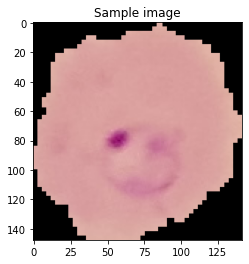

In [5]:
# Sample image

sample_image=os.listdir(train_path+"/parasitized")[0]
plt.imshow(imread(train_path+"/parasitized/"+sample_image))

plt.title('Sample image')

In [6]:
# Finding the average dimensions of the datasets since all the images have different dimensions

def find_image_dimension(path):

    dim1=[]
    dim2=[]

    for i in range(len(os.listdir(path+"/parasitized"))):

        file_para=os.listdir(path+"/parasitized")[i]
        img=imread(path+"/parasitized/"+file_para)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

    for j in range(len(os.listdir(path+"/uninfected"))):

        file_uninf=os.listdir(path+"/uninfected")[j]
        img=imread(path+"/uninfected/"+file_uninf)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

    print("Length of both arrays:",len(dim1),len(dim2))
    print("Dimension 1 average:",np.mean(dim1))
    print("Dimension 2 average:",np.mean(dim2))


    
find_image_dimension(test_path)

Length of both arrays: 2600 2600
Dimension 1 average: 132.78423076923076
Dimension 2 average: 132.03423076923076


In [7]:
# Setting the input image to (132,132,3) since the average dimensions of the image data is 132,132

IMAGE_SIZE=132
CHANNELS=3
INPUT_SHAPE=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

Text(0.5, 1.0, 'Generated image')

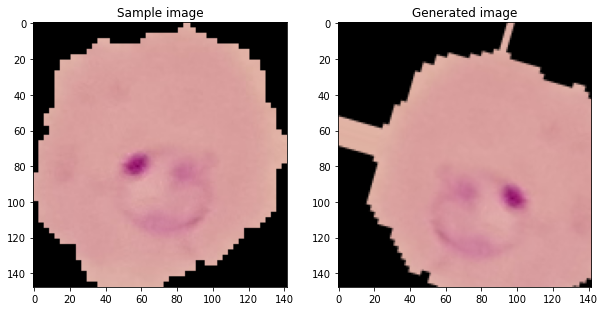

In [8]:
# ImageGenerator can be used to create more dataset. fill_mode='nearest' is a good choice. It basically picks the value of the
# nearest pixel when stretching an image

image_gen=image.ImageDataGenerator(rotation_range=20,
                            rescale=1.0/255,
                            horizontal_flip=True, 
                            shear_range=0.15, 
                            height_shift_range=0.15,
                            width_shift_range=0.15,
                            fill_mode='nearest')

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.imshow(imread(train_path+"/parasitized/"+sample_image))
plt.title('Sample image')

plt.subplot(1,2,2)
generated_image=image_gen.random_transform(imread(train_path+"/parasitized/"+sample_image))
plt.imshow(generated_image)
plt.title('Generated image')


In [9]:
# ImageGenerator's .flow_from_directory will be used to read the data. This method requires the data to be stored in a 
# particular format. So, the infected and parasitized datasets are in two separate folders for both train and test data
# and uses the names of the folders to distinguish the classes

train_image_gen=image_gen.flow_from_directory(train_path,target_size=INPUT_SHAPE[:2],class_mode='binary', 
                                               batch_size=32)

test_image_gen=image_gen.flow_from_directory(test_path,target_size=INPUT_SHAPE[:2],class_mode='binary', 
                                            batch_size=32)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [10]:
print("Training image classes:",train_image_gen.class_indices)
print("Testing image classes:",test_image_gen.class_indices)


Training image classes: {'parasitized': 0, 'uninfected': 1}
Testing image classes: {'parasitized': 0, 'uninfected': 1}


In [11]:
# Creating a CNN model

model=tf.keras.Sequential()


model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 130, 130, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 65, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9

In [13]:
# Implementing early stopping. If val_losss doesn't change more than 0.5% for 4 epochs, then stop training.

early_stop=callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.005)

history = model.fit(
    train_image_gen,
    epochs=50,
    validation_data=test_image_gen,
    callbacks=[early_stop]
)


Epoch 1/50
780/780 [==============================] - 98s 122ms/step - loss: 0.3008 - accuracy: 0.8686 - val_loss: 0.2338 - val_accuracy: 0.9327
Epoch 2/50
780/780 [==============================] - 93s 119ms/step - loss: 0.1923 - accuracy: 0.9373 - val_loss: 0.1956 - val_accuracy: 0.9304
Epoch 3/50
780/780 [==============================] - 94s 121ms/step - loss: 0.1803 - accuracy: 0.9411 - val_loss: 0.1783 - val_accuracy: 0.9400
Epoch 4/50
780/780 [==============================] - 99s 127ms/step - loss: 0.1765 - accuracy: 0.9419 - val_loss: 0.2053 - val_accuracy: 0.9331
Epoch 5/50
780/780 [==============================] - 92s 117ms/step - loss: 0.1697 - accuracy: 0.9453 - val_loss: 0.1853 - val_accuracy: 0.9381
Epoch 6/50
780/780 [==============================] - 93s 119ms/step - loss: 0.1729 - accuracy: 0.9441 - val_loss: 0.1716 - val_accuracy: 0.9438
Epoch 7/50
780/780 [==============================] - 93s 119ms/step - loss: 0.1679 - accuracy: 0.9455 - val_loss: 0.1774 - val_ac

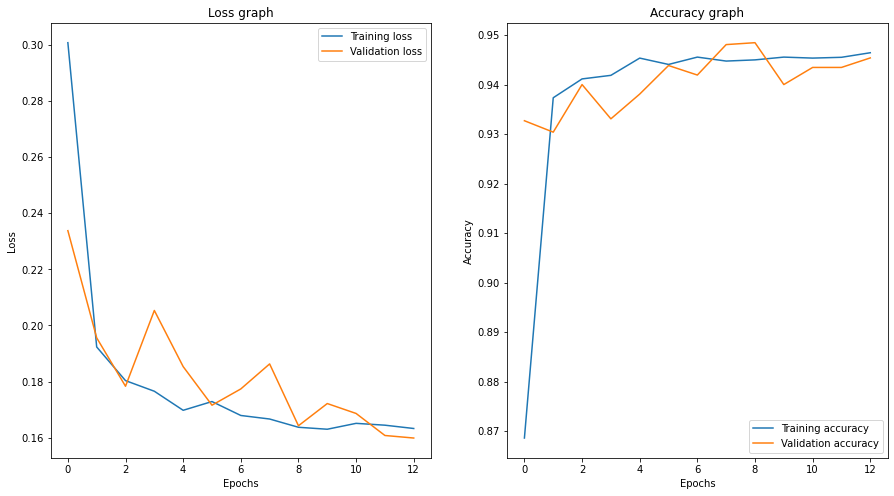

In [14]:
# plotting training graphs

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(range(len(history.history['loss'])), history.history['loss'], label="Training loss")
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label="Validation loss")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss graph')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label="Training accuracy")
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label="Validation accuracy")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy graph')
plt.legend()

In [15]:
model.evaluate(test_image_gen)

82/82 [==============================] - 9s 104ms/step - loss: 0.1587 - accuracy: 0.9477


[0.15874828398227692, 0.947692334651947]

#Testing on one single image instead of generators


 Shape of test image: (112, 145, 3)


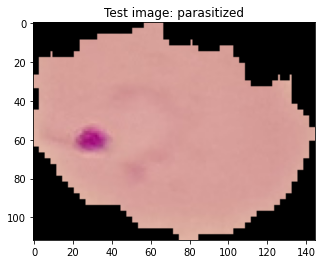

In [16]:
test_file=os.listdir(test_path+"/parasitized")[1]
test_image=test_path+"/parasitized/"+test_file
plt.imshow(imread(test_image))
plt.title('Test image: parasitized')
print("\nShape of test image: {}".format((imread(test_image)).shape))

In [17]:
# Methods for reshaping images

#converting shape (118, 118, 3) to shape (132, 132, 3)
resized_image=image.load_img(test_image,target_size=INPUT_SHAPE)
resized_image_arr=image.img_to_array(resized_image)

# since conv2d expects input in the form of (samples, width, height, color_channel), we need to reshape again

reshape_resized_img = resized_image_arr.reshape(1,INPUT_SHAPE[0],INPUT_SHAPE[1], INPUT_SHAPE[2])

# -----> another way of doing the above is:
another_reshape_img = np.expand_dims(resized_image_arr, axis=0)

print("Reshaped test image shape:",reshape_resized_img.shape)
print("\nAnother method shape:",another_reshape_img.shape)

Reshaped test image shape: (1, 132, 132, 3)

Another method shape: (1, 132, 132, 3)


In [18]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [19]:
value=model.predict(reshape_resized_img).astype('uint8')[0][0]

print("Predicted value:",[key for key,val in test_image_gen.class_indices.items()][value])

Predicted value: parasitized
